In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
user_df = pd.read_csv('data\\ratings.csv')
user_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies_df = pd.read_csv('data\\movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print('Number of users: ', len(pd.unique(user_df['userId'])))
print('Number of movies: ', len(pd.unique(movies_df['movieId'])))

Number of users:  610
Number of movies:  9742


# Exploring the genres

## First, we'll look at the number of times each of the listed genres has been assigned to a movie in the data set

From the plot, we can see that Drama is the most populous genre in the data set with 4361 occurences. This is followed by Comedy, Thriller, Action, and Romance

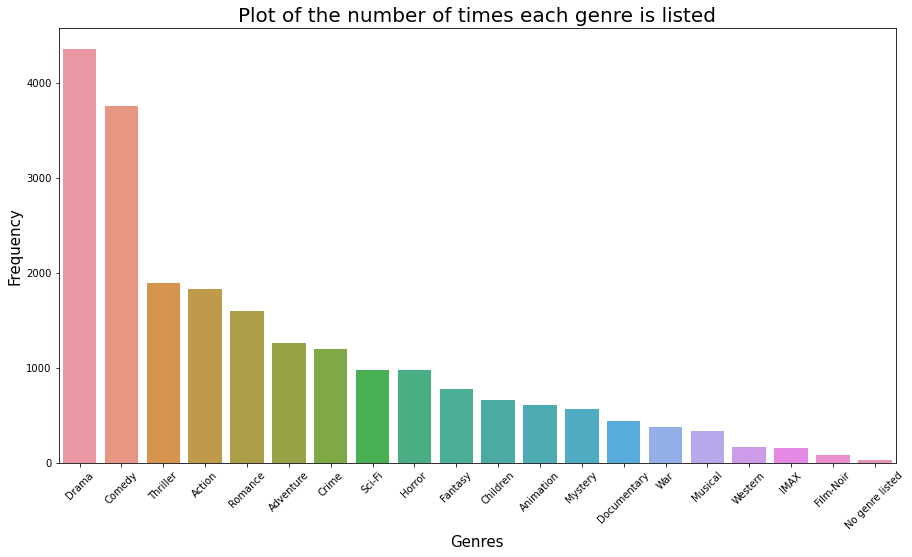

In [5]:
#Find out the frequency of genres
genres = movies_df['genres'].str.split("[|, ' ']",expand=True).stack().value_counts()
genres['No genre listed'] = genres['(no']
del genres['genres']
del genres['listed)']
del genres['(no']
keys = list(genres.keys())
values = [genres[k] for k in keys]
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Plot of the number of times each genre is listed',fontsize=20)
sns.barplot(x=keys, y=values)

In [6]:
#TODO
#find 5 movies with highest consolidated ratings, and their genres
#find 5 movies with lowest consolidated ratings, and their genres
#find the genres with the highest normalized rating (add the ratings together for each movie that has a specific 
# genre, divide it by the number of times that genre comes up)
#find the preferences of a single user

## Let's look at the highest and the worst rated movies and the genres they are listed under

In [7]:
#Sort the movie ids by arithmetic means of their rating, non-ascending
sorted_rating = user_df[['movieId','rating']].groupby('movieId').mean().sort_values(by='rating', ascending=False)
#Join the movies db with movieId to find the names of the movies
sorted_rating_names = pd.merge(sorted_rating, movies_df, on = 'movieId')
sorted_rating_names.head()


,movieId,rating,title,genres
0,88448,5.0,Paper Birds (Pájaros de papel) (2010),Comedy|Drama
1,100556,5.0,"Act of Killing, The (2012)",Documentary
2,143031,5.0,Jump In! (2007),Comedy|Drama|Romance
3,143511,5.0,Human (2015),Documentary
4,143559,5.0,L.A. Slasher (2015),Comedy|Crime|Fantasy


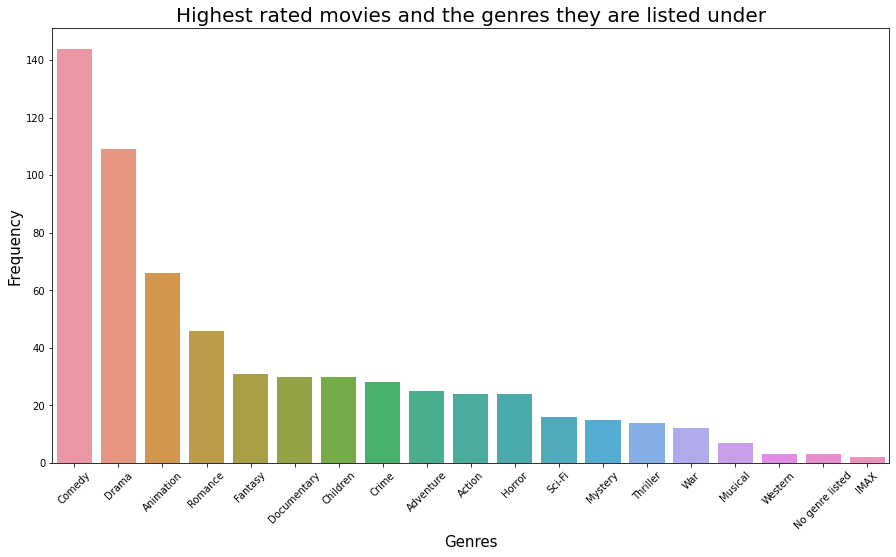

In [8]:
#Get the genres of the movies rated five stars and plot their distribution
genres_top = sorted_rating_names[sorted_rating_names['rating'] == 5.0]['genres'].str.split("[|, ' ']", expand=True).stack().value_counts()
genres_top['No genre listed'] = genres_top['(no']
del genres_top['genres']
del genres_top['listed)']
del genres_top['(no']
genres_top = dict(sorted(genres_top.items(), key=lambda item: item[1], reverse=True))
keys = list(genres_top.keys())
values = [genres_top[k] for k in keys]
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Highest rated movies and the genres they are listed under',fontsize=20)
sns.barplot(x=keys, y=values)

People seem to enjoy comedy movies the most, as this category has the most number of films rated 5 stars. 

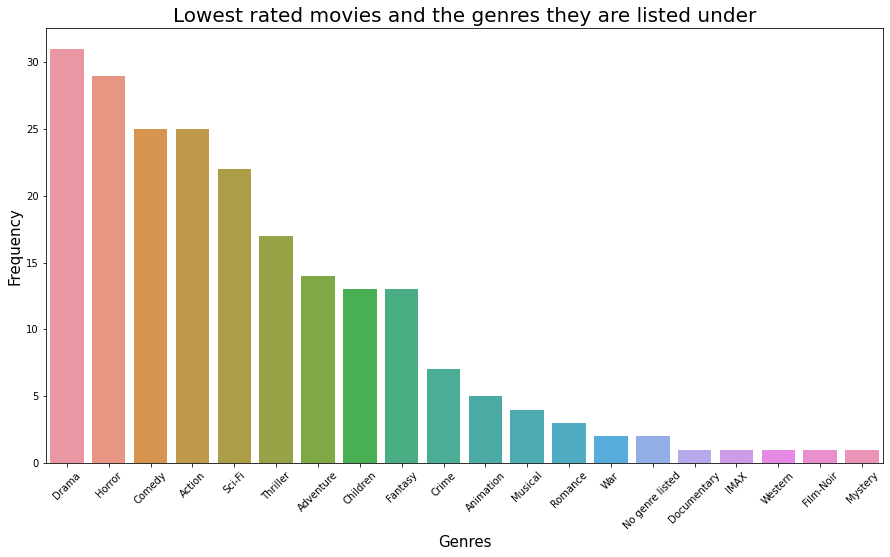

In [9]:
#Get the genres of the movies rated 0.5 stars and plot their distribution
genres_low = sorted_rating_names[sorted_rating_names['rating'] == 0.5]['genres'].str.split("[|, ' ']", expand=True).stack().value_counts()
genres_low['No genre listed'] = genres_low['(no']
del genres_low['genres']
del genres_low['listed)']
del genres_low['(no']
genres_low = dict(sorted(genres_low.items(), key=lambda item: item[1], reverse=True))
keys = list(genres_low.keys())
values = [genres_low[k] for k in keys]
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Lowest rated movies and the genres they are listed under',fontsize=20)
sns.barplot(x=keys, y=values)

Drama and horror seem to lead in this category as the genres of the worst rated movies. An interesting fact here is that drama is in both the best rated and worst rated movies. This may indicate that the dataset in unbalanced and that a high number of movies tend to be classified under the genre 'Drama'

# Let's try to find the genres that have received the highest consolidated rating

In [10]:
def return_genre_consolidated_rating(df):
    #first let's replace (No genres listed) with an easily splittable value
    df['genres'] = df['genres'].str.replace('(no genres listed)', 'no_genre_listed', regex = False)
    #now split the genres column
    stacked_df = pd.DataFrame(df['genres'].str.split("[|, ' ']",expand=True).stack())
    stacked_df.reset_index(inplace=True)
    stacked_df.columns = ['movieId', 'genreNumber', 'genre']
    df = pd.merge(df, stacked_df, on = 'movieId')
    df = df[['genre', 'rating']].groupby('genre').mean()
    df = df.reset_index()
    return df

Text(0, 0.5, 'Average Rating')

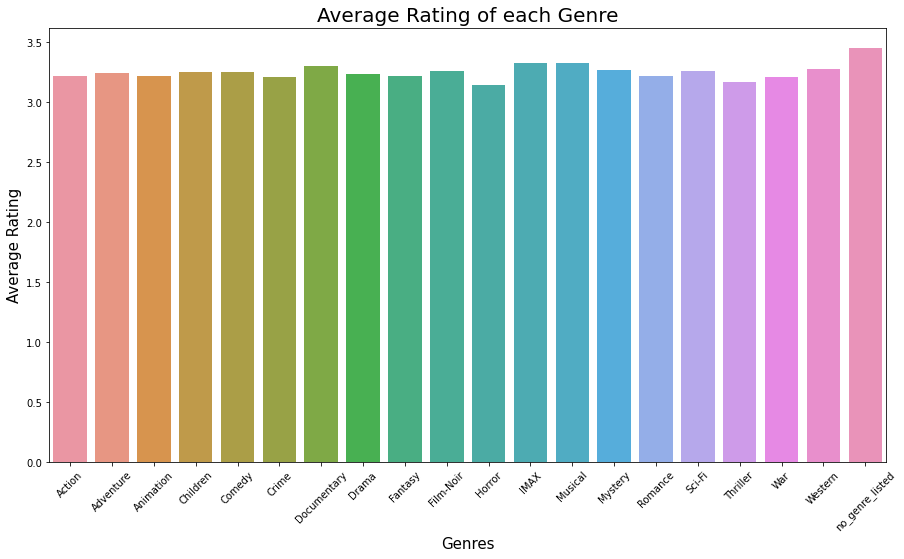

In [11]:
consolidated_genre_rating = return_genre_consolidated_rating(sorted_rating_names)
#consolidated_genre_rating.reset_index()
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.title('Average Rating of each Genre',fontsize=20)
sns.barplot(x = consolidated_genre_rating['genre'], y = consolidated_genre_rating['rating'])
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Average Rating', fontsize=15)

It seems we do not get any useful insights from this analysis. The average rating for each genre tends towards the 'average' possible rating i.e. 3 

# Analysing the preferences of a single user

Let's try to look at the number of ratings a user has submitted, his/her favorite movies and the genres they come under, his/her least favorite movies and the genres they fall under

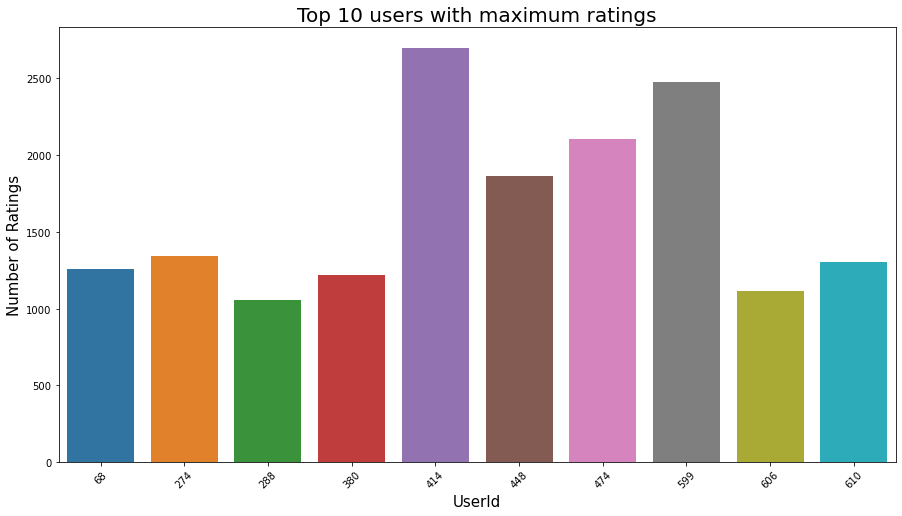

In [12]:
user_rating_count = user_df['userId'].value_counts().iloc[:10]
user_rating_count = dict(sorted(user_rating_count.items(), key=lambda item: item[1], reverse=True))
keys = list(user_rating_count.keys())
values = [user_rating_count[k] for k in keys]
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.xlabel('UserId', fontsize=15)
plt.ylabel('Number of Ratings', fontsize=15)
plt.title('Top 10 users with maximum ratings',fontsize=20)
sns.barplot(x=keys, y=values)

In [13]:
#Lets analysze user 414 since he/she has rated the maximum number of movies
#1. Movies rated 5 stars liked by user 414
#2. Genres of the movies rated 5 stars by user 414
#3. Movies rated 0.5 stars by user 414
#4. Genres of the movies rated 0.5 stars by user 414

In [14]:
#1
df_user_414 = pd.merge(user_df[user_df['userId'] == 414], movies_df, on = 'movieId')
print('Movies rated 5 stars by user 414:')
df_user_414[df_user_414.rating == 5.0][['title', 'genres']]

Movies rated 5 stars by user 414:


,title,genres
8,"American President, The (1995)",Comedy|Drama|Romance
20,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
21,Babe (1995),Children|Drama
30,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
45,Beautiful Girls (1996),Comedy|Drama|Romance
...,...,...
2672,The Big Sick (2017),Comedy|Romance
2675,Band of Brothers (2001),Action|Drama|War
2676,Baby Driver (2017),Action|Crime|Thriller
2681,Dunkirk (2017),Action|Drama|Thriller|War


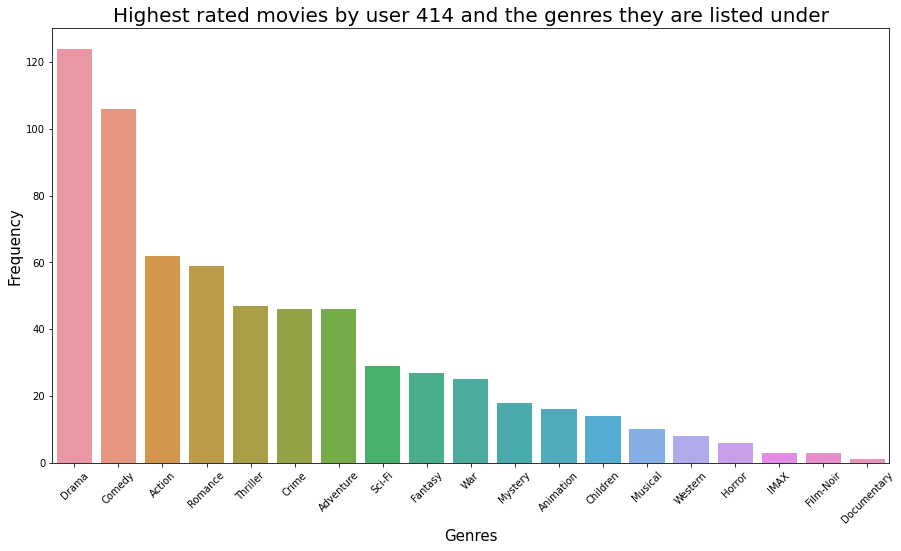

In [15]:
#2
genres_top_414 = df_user_414[df_user_414['rating'] == 5.0]['genres'].str.split("[|, ' ']", expand=True).stack().value_counts()
keys = list(genres_top_414.keys())
values = [genres_top_414[k] for k in keys]
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Highest rated movies by user 414 and the genres they are listed under',fontsize=20)
sns.barplot(x=keys, y=values)

Drama, Comedy, and Action seem to be user 414s favorite genres of movies

In [16]:
#3
print('Movies rated 1 stars or less by user 414:')
df_user_414[df_user_414.rating <= 1][['title', 'genres']]

Movies rated 1 stars or less by user 414:


,title,genres
32,"Big Green, The (1995)",Children|Comedy
38,Big Bully (1996),Comedy|Drama
69,Congo (1995),Action|Adventure|Mystery|Sci-Fi
79,Jury Duty (1995),Comedy
102,Destiny Turns on the Radio (1995),Comedy
159,"Flintstones, The (1994)",Children|Comedy|Fantasy
169,Richie Rich (1994),Children|Comedy
291,Multiplicity (1996),Comedy
299,Thinner (1996),Horror|Thriller
319,"First Wives Club, The (1996)",Comedy


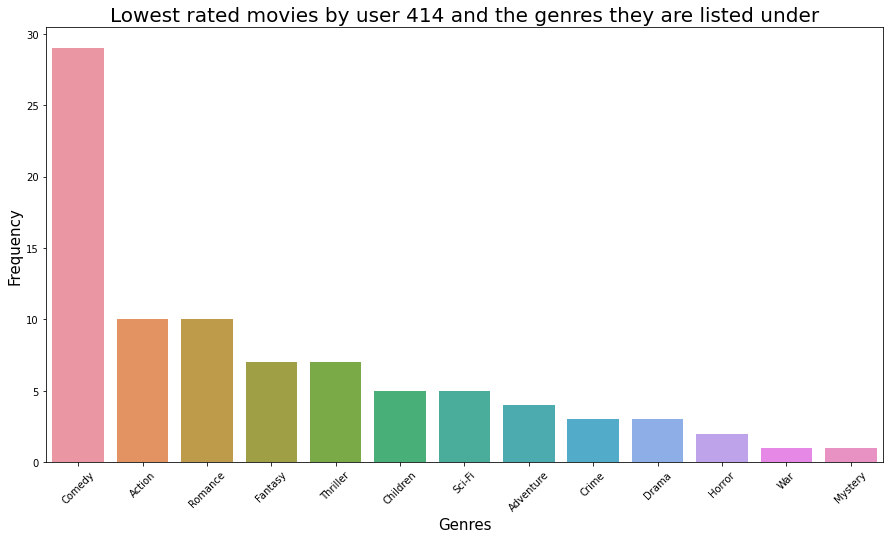

In [17]:
#4
genres_low_414 = df_user_414[df_user_414['rating'] <= 1.0]['genres'].str.split("[|, ' ']", expand=True).stack().value_counts()
keys = list(genres_low_414.keys())
values = [genres_low_414[k] for k in keys]
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Lowest rated movies by user 414 and the genres they are listed under',fontsize=20)
sns.barplot(x=keys, y=values)

Comedy comes up in the worst rated movies of user 414 as well. This probably indicates that way too many movies are classified under this genre but deliver substandard performance. Comedy is disproportionately high compared to the other genres. Also, the fact that this genre comes up in both best rated and worst rated movies probably implies that user 414 has watched/actively watches comedy movies more than other genres.

# Collaborative Filtering with Matrix Factorization

Consult https://github.com/minz27/matrix-factorization/blob/main/Matrix%20Factorization%20with%20Numpy.ipynb for the code.
I will be using a non-weighted matrix factorization with a static user-item matrix as the whole point of this exercise was to simply implement collaborative filtering on a dataset.

In [99]:
class collaborative_filtering():
    
    def __init__(self, data, features):
        self.data = data
        self.features = features
        self.user_count = data.shape[0]
        self.item_count = data.shape[1]
        #initialize the user_features vector and the item_features vector to pseudo-random values between 0.1 and 0.9
        self.user_features = np.random.uniform(low = 0.1, high = 0.9, size = (self.user_count, self.features))
        self.item_features = np.random.uniform(low = 0.1, high = 0.9, size = (self.item_count, self.features))
    
    def MSE(self):
        data_calc = np.matmul(self.user_features, np.transpose(self.item_features))
        return np.sum((self.data - data_calc)**2)
    
    def calculate_user_feature_gradient(self):
        return np.matmul(self.data - np.matmul(self.user_features, np.transpose(self.item_features)), self.item_features)

    def calculate_item_feature_gradient(self):
        return np.matmul(np.transpose(self.data - np.matmul(self.user_features, np.transpose(self.item_features))), self.user_features)

    def update_user_feature(self, learning_rate):
        self.user_features += (learning_rate/(2*self.user_features.shape[0]))*self.calculate_user_feature_gradient()
        
    def update_item_feature(self, learning_rate):
        self.item_features += (learning_rate/(2*self.item_features.shape[0]))*self.calculate_item_feature_gradient()
    
    def train_model(self, learning_rate=0.1, iterations=10000):
        for i in range(iterations):
            self.update_user_feature(learning_rate)
            self.update_item_feature(learning_rate)
            if(i % 500 == 0):
                print("Iteration number:", i)
                print(self.MSE())
        return self.MSE() #for evaluation purposes        

In [96]:
#Let's get the data in the required format for collaborative filtering
#A sparse matrix of dimensions (user_count X movies_count) will be created and will be populated with the rating 
#given by the userId to the corresponding movieId. If the user has not rated a movie, it will be defaulted to 0
user_item_df = pd.merge(user_df[['userId', 'rating', 'movieId']], movies_df, on='movieId')
user_item_df = user_item_df.pivot(index='userId', columns = 'movieId', values = 'rating').fillna(0)
user_item_matrix = user_item_df.to_numpy()

In [ ]:
#Let's see how results change with different number of features
# matmul overflows in numpy when we multiply large number of features :(
number_of_features = [5,10,15,20]
results = []
for feature in number_of_features:
    print("For number of features: ", feature)
    test = collaborative_filtering(user_item_matrix, feature)
    results.append(test.train_model(learning_rate=0.1))

For number of features:  5
Iteration number: 0
1354800.1978211107
Iteration number: 500
1272230.6188742523
Iteration number: 1000
1260070.6217927565
Iteration number: 1500
1216539.8957391956
Iteration number: 2000
1118997.6935046762
Iteration number: 2500
1063569.3464823682
Iteration number: 3000
1052234.1926120927
Iteration number: 3500
1050268.2079813122
Iteration number: 4000
1049560.6979685822
Iteration number: 4500
1048826.2077438794
Iteration number: 5000
1047767.3378998125
Iteration number: 5500
1046167.7562364724
Iteration number: 6000
1043760.0101261411
Iteration number: 6500
1040234.6128805294
Iteration number: 7000
1035336.254927575
Iteration number: 7500
1029047.6342064078
Iteration number: 8000
1021764.4128732979
Iteration number: 8500
1014253.6656764298
Iteration number: 9000
1007317.2509245093
Iteration number: 9500
1001419.8597551087
For number of features:  10
Iteration number: 0
39729262.269420855
Iteration number: 500
1272721.5163186004
Iteration number: 1000
1263347

[1, 2]